In [1]:
import os
import yaml
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datetime import datetime
from pathlib import Path
from matplotlib.patches import Rectangle

from utils import *

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\Jesper\Documents\GitHub Local\ARFusion


In [2]:
with open('config_MM.yaml' ,'r') as file:
    config = yaml.safe_load(file)

ds_NCBI = pd.read_pickle(config['data']['NCBI']['load_path'])
ds_TESSy = pd.read_pickle(config['data']['TESSy']['load_path'])

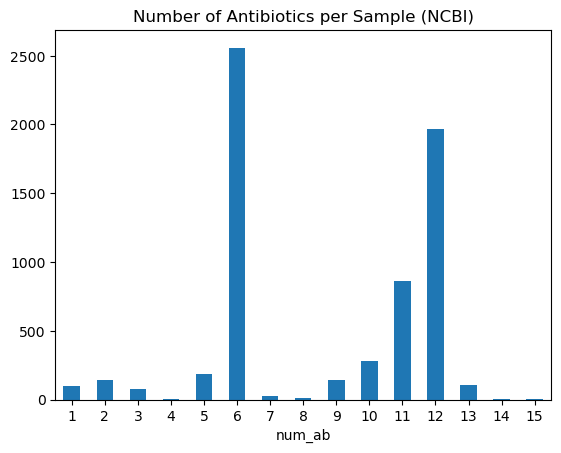

In [3]:
ds_NCBI[ds_NCBI['num_ab'] > 0]['num_ab'].astype('int').value_counts().sort_index().plot(kind='bar', rot=0)
plt.title('Number of Antibiotics per Sample (NCBI)')
plt.show()

# Experiment with weighted loss based on data imbalance

In [4]:
def get_pivot_from_processed_datasets(ds, colname = 'phenotypes'):
    df_pivot = ds[colname].explode().value_counts().reset_index()
    df_pivot.columns = ['phenotype', 'count']
    df_pivot['Antibiotic'] = df_pivot['phenotype'].apply(lambda x: x.split('_')[0])
    df_pivot['SR'] = df_pivot['phenotype'].apply(lambda x: x.split('_')[1])
    df_pivot = df_pivot.drop(columns='phenotype').set_index('Antibiotic')
    df_pivot = df_pivot.pivot(columns='SR', values='count').fillna(0)
    df_pivot = df_pivot[['S', 'R']]
    df_pivot[['S_share', 'R_share']] = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    df_pivot['Total'] = df_pivot['S'] + df_pivot['R']
    df_pivot = df_pivot[['Total', 'S', 'R', 'S_share', 'R_share']]
    
    return df_pivot

pivot_TESSy = get_pivot_from_processed_datasets(ds_TESSy)
pivot_NCBI = get_pivot_from_processed_datasets(ds_NCBI)

In [5]:
pivot_NCBI

SR,Total,S,R,S_share,R_share
Antibiotic,,,,,
AMK,3260,3211,49,0.984969,0.015031
AMP,6095,3275,2820,0.537326,0.462674
CAZ,3329,2388,941,0.717333,0.282667
CIP,6168,4997,1171,0.810149,0.189851
CRO,5811,4713,1098,0.811048,0.188952
CTX,843,134,709,0.158956,0.841044
ETP,3199,3095,104,0.967490,0.032510
FEP,3266,2655,611,0.812921,0.187079
GEN,6059,5274,785,0.870441,0.129559


In [6]:
pivot_TESSy

SR,Total,S,R,S_share,R_share
Antibiotic,,,,,
AMK,716400,708757,7643,0.989331,0.010669
AMP,923116,409186,513930,0.443266,0.556734
CAZ,1225411,1123675,101736,0.916978,0.083022
CIP,1327086,1066212,260874,0.803423,0.196577
CRO,394256,358251,36005,0.908676,0.091324
CTX,1106178,995114,111064,0.899597,0.100403
ETP,352826,351992,834,0.997636,0.002364
FEP,298871,270585,28286,0.905357,0.094643
GEN,1245501,1145646,99855,0.919827,0.080173


In [7]:
weights = config['data']['antibiotics']['ab_weights_strong']
weights = {k: v for k, v in weights.items() if k in pivot_TESSy.index}
pivot_weights = pd.DataFrame.from_dict(weights, orient='index')
pivot_weights.columns = ['S', 'R']
pivot_weights = pivot_weights.sort_values(by='S')
pivot_NCBI = pivot_NCBI.reindex(pivot_weights.index)
pivot_TESSy = pivot_TESSy.reindex(pivot_weights.index)

In [8]:
pivot_weights

,S,R
AMK,0.1,0.9
ETP,0.1,0.9
IPM,0.1,0.9
MEM,0.1,0.9
NAL,0.1,0.9
TOB,0.1,0.9
CIP,0.2,0.8
CRO,0.2,0.8
FEP,0.2,0.8
GEN,0.2,0.8


In [9]:
weights_mild = config['data']['antibiotics']['ab_weights_mild']
weights_mild = {k: v for k, v in weights_mild.items() if k in pivot_TESSy.index}
pivot_weights_mild = pd.DataFrame.from_dict(weights_mild, orient='index')
pivot_weights_mild.columns = ['S', 'R']
pivot_weights_mild = pivot_weights_mild.reindex(pivot_weights.index)

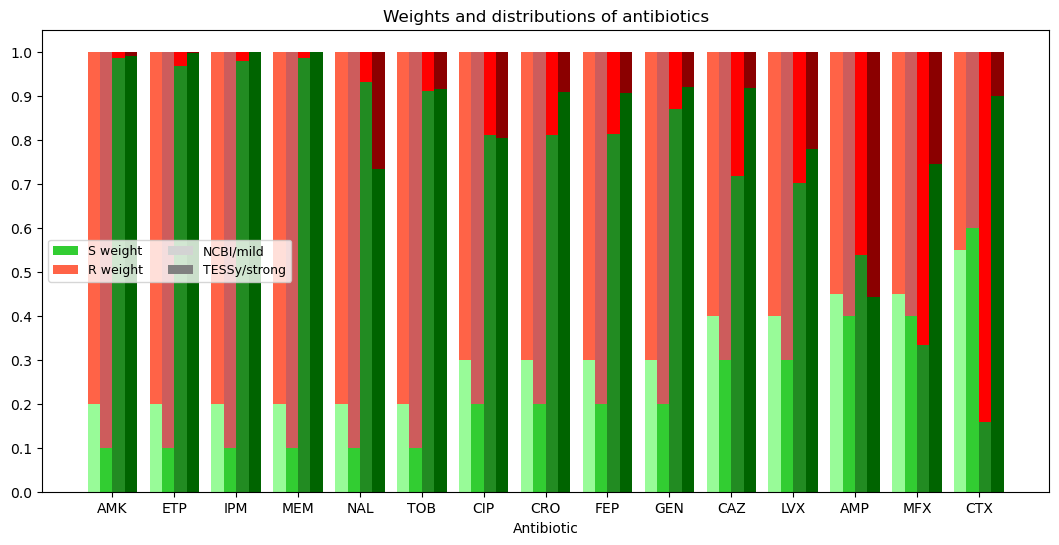

In [10]:
fig, ax = plt.subplots(figsize=(13, 6))
bar_width = 0.2
ind = np.arange(len(pivot_TESSy.index))
ax.bar(ind - 3*bar_width/2, pivot_weights_mild['S'], width=bar_width, color='palegreen')
ax.bar(ind - 3*bar_width/2, pivot_weights_mild['R'], width=bar_width, bottom=pivot_weights_mild['S'], color='tomato')
ax.bar(ind - bar_width/2, pivot_weights['S'], width=bar_width, color='limegreen')
ax.bar(ind - bar_width/2, pivot_weights['R'], width=bar_width, bottom=pivot_weights['S'], color='indianred')
ax.bar(ind + bar_width/2, pivot_NCBI['S_share'], width=bar_width, color='forestgreen')
ax.bar(ind + bar_width/2, pivot_NCBI['R_share'], width=bar_width, bottom=pivot_NCBI['S_share'], color='red')
ax.bar(ind + 3*bar_width/2, pivot_TESSy['S_share'], width=bar_width, color='darkgreen')
ax.bar(ind + 3*bar_width/2, pivot_TESSy['R_share'], width=bar_width, bottom=pivot_TESSy['S_share'], color='darkred')
ax.set_xticks(ind, pivot_TESSy.index)
ax.set_xlabel('Antibiotic')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_title("Weights and distributions of antibiotics")

S_weight = Rectangle((0,0),1,1,fc="limegreen")
R_weight = Rectangle((0,0),1,1,fc="tomato")
NCBI = Rectangle((0,0),1,1,fc="lightgrey")
TESSy = Rectangle((0,0),1,1,fc="grey")

handles = [S_weight, R_weight, NCBI, TESSy]
labels = ['S weight',  'R weight', 'NCBI/mild', 'TESSy/strong']

ax.legend(handles, labels, ncols=2, loc='center left', fontsize=9)
plt.show()

## p = (0.75, 0.75)

In [11]:
results_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_noWL_test_0.75_0.75', 'results.pkl'))
results_noPT_mild = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_mildWL_test_0.75_0.75', 'results.pkl'))
results_noPT_strong = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_WL_test_0.75_0.75', 'results.pkl'))
results_hardRPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_noWL_test_hardRPT_0.75_0.75', 'results.pkl'))
results_hardRPT_mild = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_mildWL_test_hardRPT_0.75_0.75', 'results.pkl'))
results_hardRPT_strong = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_WL_test_hardRPT_0.75_0.75', 'results.pkl'))

model_names = ['noPT', 'noPT_mild', 'noPT_strong', 'hardRPT', 'hardRPT_mild', 'hardRPT_strong']
colors = ['skyblue', 'dodgerblue', 'blue', 'lightcoral', 'red', 'darkred']
results = [results_noPT, results_noPT_mild, results_noPT_strong, results_hardRPT, results_hardRPT_mild, results_hardRPT_strong]

sensitivities = [r['sens'] for r in results]
specificities = [r['spec'] for r in results]
accuracies = [r['acc'] for r in results]
f1_scores = [r['F1'] for r in results]

res_df = pd.DataFrame({
    'model': model_names, 
    'Sensitivity': sensitivities, 
    'Specificity': specificities, 
    'Accuracy': accuracies, 
    'F1': f1_scores
}).set_index('model').T
res_df

model,noPT,noPT_mild,noPT_strong,hardRPT,hardRPT_mild,hardRPT_strong
Sensitivity,0.769774,0.825565,0.853814,0.777542,0.824153,0.849576
Specificity,0.984777,0.962373,0.941405,0.985638,0.968404,0.947580
Accuracy,0.948443,0.939253,0.926602,0.950471,0.944027,0.931018
F1,0.834609,0.821215,0.797230,0.841421,0.832679,0.806300


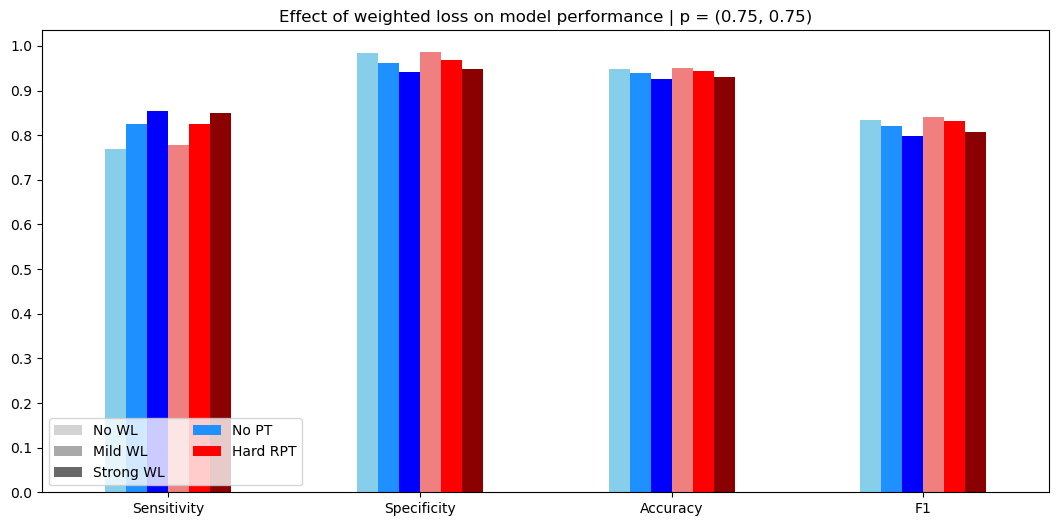

In [12]:
fig, ax = plt.subplots(figsize=(13, 6))

res_df.plot(kind='bar', ax=ax, rot=0, color=colors, legend=False)

no_pt = Rectangle((0,0),1,1,fc="dodgerblue")
rpt = Rectangle((0,0),1,1,fc="red")
no_wl = Rectangle((0,0),1,1,fc="lightgrey")
mild_wl = Rectangle((0,0),1,1,fc="darkgray")
wl = Rectangle((0,0),1,1,fc="dimgrey")

handles = [no_wl, mild_wl, wl, no_pt, rpt]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT']
ax.legend(handles, labels, loc='lower left', fontsize=10, ncols=2)
ax.set_title('Effect of weighted loss on model performance | p = (0.75, 0.75)')
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.show()

In [13]:
ab_stats_list = [r['ab_stats'].set_index('antibiotic') for r in results]
res_df_ab = pd.concat(ab_stats_list, keys=model_names, names=['model']).unstack(level=0)
res_df_ab
reduce_cols = ['num_masked_tot', 'num_masked_S', 'num_masked_R']
df_tmp = res_df_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_tmp.insert(i, col, res_df_ab[col].agg('mean', axis=1))
res_df_ab = df_tmp
S_share = res_df_ab['num_masked_S'] / res_df_ab['num_masked_tot']
R_share = res_df_ab['num_masked_R'] / res_df_ab['num_masked_tot']
res_df_ab[['S_share', 'R_share']] = pd.concat([S_share, R_share], axis=1)
res_df_ab = res_df_ab.sort_values(by='S_share', ascending=False)
res_df_ab

num_masked_tot num_masked_S num_masked_R num_pred_S            \
model                                                     noPT noPT_mild   
antibiotic                                                                 
MEM                 886.0        880.0          6.0        880       878   
IPM                 410.0        404.0          6.0        401       401   
AMK                 507.0        498.0          9.0        505       500   
ETP                 473.0        463.0         10.0        464       462   
TOB                 393.0        370.0         23.0        370       361   
NAL                 493.0        460.0         33.0        474       455   
GEN                 913.0        797.0        116.0        836       799   
CIP                 923.0        766.0        157.0        793       739   
FEP                 482.0        391.0         91.0        404       384   
CRO                 873.0        708.0        165.0        733       707   
LVX                 425.0        311.0        114.0        314       298   
CAZ                 526.0        377.0        149.0        393       370   
AMP                 929.0        508.0        421.0        587       572   
MFX                   7.0          3.0          4.0          2         1   
CTX                 139.0         27.0        112.0         27        21   

                                                           num_pred_R  ...  \
model      noPT_strong hardRPT hardRPT_mild hardRPT_strong       noPT  ...   
antibiotic                                                             ...   
MEM                872     881          880            875          6  ...   
IPM                396     402          399            398          9  ...   
AMK                490     503          502            498          2  ...   
ETP                451     466          459            454          9  ...   
TOB                338     370          358            346         23  ...   
NAL                430     475          456            434         19  ...   
GEN                776     834          813            777         77  ...   
CIP                728     791          739            719        130  ...   
FEP                367     397          381            372         78  ...   
CRO                693     728          717            704        140  ...   
LVX                304     317          302            288        111  ...   
CAZ                346     395          381            364        133  ...   
AMP                543     590          575            552        342  ...   
MFX                  1       2            1              1          5  ...   
CTX                 27      27           29             29        112  ...   

              precision                       F1                        \
model      hardRPT_mild hardRPT_strong      noPT noPT_mild noPT_strong   
antibiotic                                                               
MEM            0.666667       0.363636  0.666667  0.571429    0.400000   
IPM            0.545455       0.500000  0.666667  0.666667    0.600000   
AMK            0.600000       0.444444  0.363636  0.500000    0.307692   
ETP            0.428571       0.315789  0.526316  0.571429    0.375000   
TOB            0.600000       0.446809  0.739130  0.654545    0.564103   
NAL            0.675676       0.474576  0.692308  0.676056    0.604167   
GEN            0.730000       0.580882  0.683938  0.660870    0.648221   
CIP            0.777174       0.725490  0.850174  0.838710    0.818182   
FEP            0.762376       0.718182  0.781065  0.761905    0.757282   
CRO            0.916667       0.869822  0.872131  0.858006    0.857971   
LVX            0.829268       0.759124  0.862222  0.863071    0.868085   
CAZ            0.896552       0.833333  0.886525  0.872131    0.832827   
AMP            0.906780       0.872679  0.828309  0.830334    0.827757   
MFX            0.666667       0.666667  0.888889  0.8

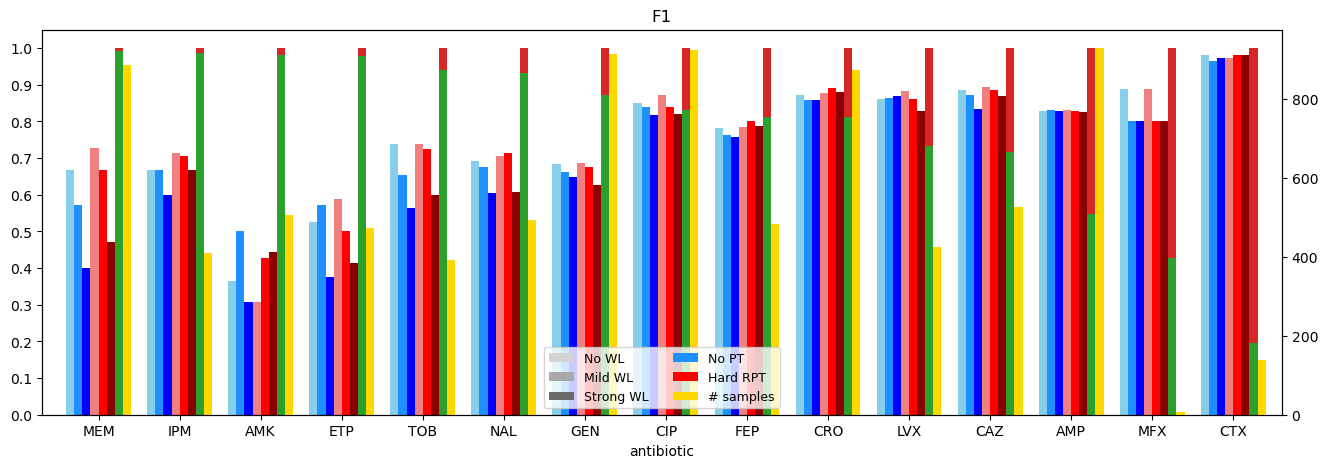

In [14]:
fig, ax = plt.subplots(figsize=(16, 5))

ax2 = ax.twinx()
metric = 'F1'
bar_width = 0.1
for i, model in enumerate(model_names):
    res_df_ab[metric][model].plot(kind='bar', ax=ax, color=colors[i], position=-i+4, width=bar_width, label=model, legend=False, rot=0)

res_df_ab[['S_share', 'R_share']].plot(kind='bar', ax=ax, position=-2, stacked=True, width=bar_width, color=['tab:green', 'tab:red'], rot=0, legend=False)
res_df_ab['num_masked_tot'].plot(kind='bar', ax=ax2, color='gold', label='Total masked', position=-3, width=bar_width, legend=False, rot=0)
ax.set_xlim(-0.7, len(res_df_ab.index)-0.4)
ax.set_title(metric)
ax.set_yticks(np.arange(0, 1.1, 0.1))

n_samples = Rectangle((0,0),1,1,fc="gold")

handles = [no_wl, mild_wl, wl, no_pt, rpt, n_samples]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT', '# samples']
# ax.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)
ax2.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)

plt.show()

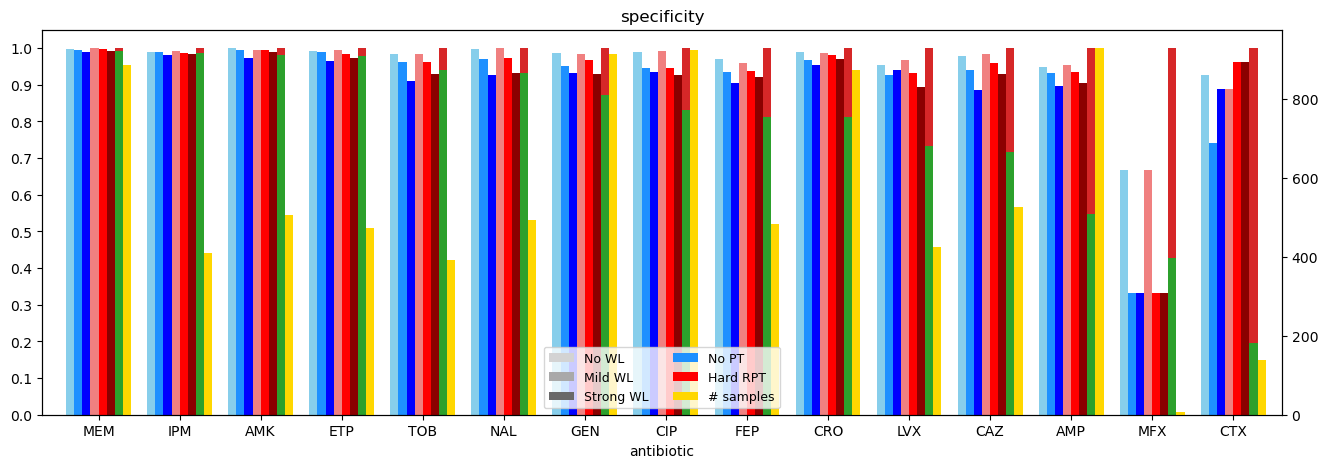

In [15]:
fig, ax = plt.subplots(figsize=(16, 5))

ax2 = ax.twinx()
metric = 'specificity'
bar_width = 0.1
for i, model in enumerate(model_names):
    res_df_ab[metric][model].plot(kind='bar', ax=ax, color=colors[i], position=-i+4, width=bar_width, label=model, legend=False, rot=0)

res_df_ab[['S_share', 'R_share']].plot(kind='bar', ax=ax, position=-2, stacked=True, width=bar_width, color=['tab:green', 'tab:red'], rot=0, legend=False)
res_df_ab['num_masked_tot'].plot(kind='bar', ax=ax2, color='gold', label='Total masked', position=-3, width=bar_width, legend=False, rot=0)
ax.set_xlim(-0.7, len(res_df_ab.index)-0.4)
ax.set_title(metric)
ax.set_yticks(np.arange(0, 1.1, 0.1))

n_samples = Rectangle((0,0),1,1,fc="gold")

handles = [no_wl, mild_wl, wl, no_pt, rpt, n_samples]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT', '# samples']
# ax.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)
ax2.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)

plt.show()

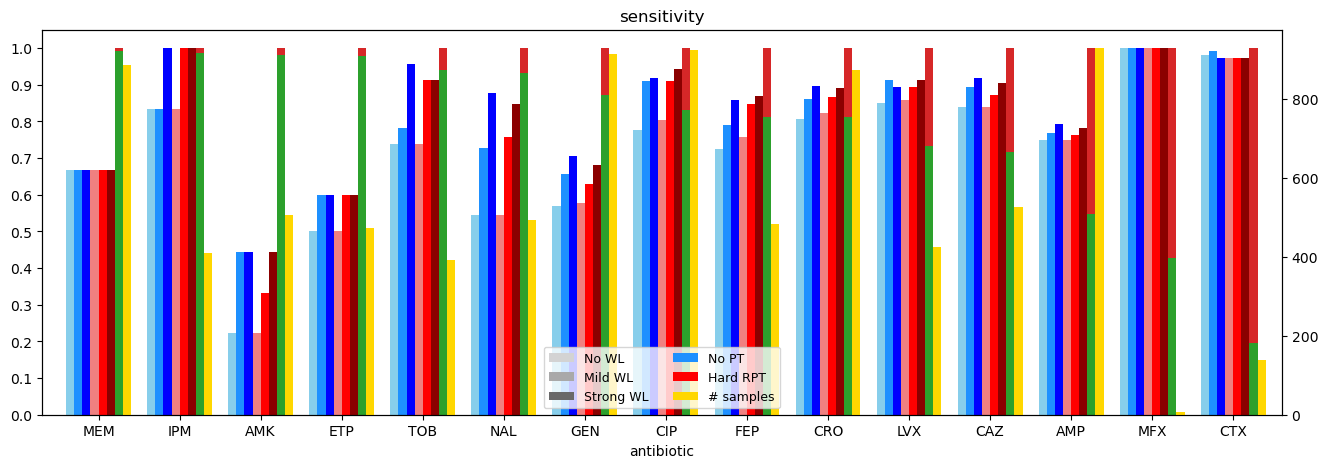

In [16]:
fig, ax = plt.subplots(figsize=(16, 5))

ax2 = ax.twinx()
metric = 'sensitivity'
bar_width = 0.1
for i, model in enumerate(model_names):
    res_df_ab[metric][model].plot(kind='bar', ax=ax, color=colors[i], position=-i+4, width=bar_width, label=model, legend=False, rot=0)

res_df_ab[['S_share', 'R_share']].plot(kind='bar', ax=ax, position=-2, stacked=True, width=bar_width, color=['tab:green', 'tab:red'], rot=0, legend=False)
res_df_ab['num_masked_tot'].plot(kind='bar', ax=ax2, color='gold', label='Total masked', position=-3, width=bar_width, legend=False, rot=0)
ax.set_xlim(-0.7, len(res_df_ab.index)-0.4)
ax.set_title(metric)
ax.set_yticks(np.arange(0, 1.1, 0.1))

n_samples = Rectangle((0,0),1,1,fc="gold")

handles = [no_wl, mild_wl, wl, no_pt, rpt, n_samples]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT', '# samples']
# ax.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)
ax2.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)

plt.show()

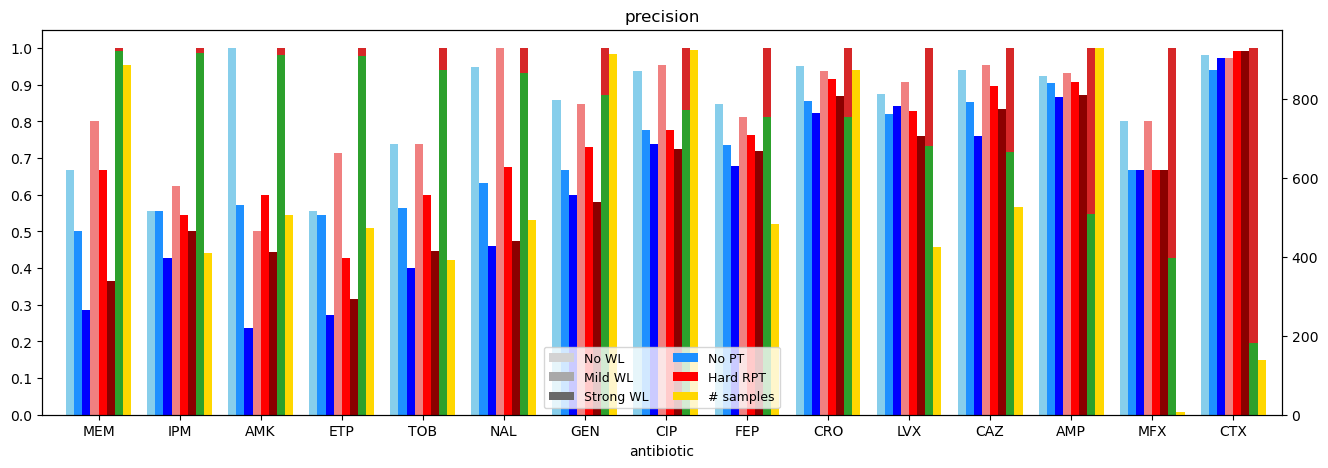

In [17]:
fig, ax = plt.subplots(figsize=(16, 5))

ax2 = ax.twinx()
metric = 'precision'
bar_width = 0.1
for i, model in enumerate(model_names):
    res_df_ab[metric][model].plot(kind='bar', ax=ax, color=colors[i], position=-i+4, width=bar_width, label=model, legend=False, rot=0)

res_df_ab[['S_share', 'R_share']].plot(kind='bar', ax=ax, position=-2, stacked=True, width=bar_width, color=['tab:green', 'tab:red'], rot=0, legend=False)
res_df_ab['num_masked_tot'].plot(kind='bar', ax=ax2, color='gold', label='Total masked', position=-3, width=bar_width, legend=False, rot=0)
ax.set_xlim(-0.7, len(res_df_ab.index)-0.4)
ax.set_title(metric)
ax.set_yticks(np.arange(0, 1.1, 0.1))

n_samples = Rectangle((0,0),1,1,fc="gold")

handles = [no_wl, mild_wl, wl, no_pt, rpt, n_samples]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT', '# samples']
# ax.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)
ax2.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)

plt.show()

## p = (0.75, 0.5)

In [18]:
results_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_noWL_test_0.75_0.5', 'results.pkl'))
results_noPT_mild = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_mildWL_test_0.75_0.5', 'results.pkl'))
results_noPT_strong = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_WL_test_0.75_0.5', 'results.pkl'))
results_hardRPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_noWL_test_hardRPT_0.75_0.5', 'results.pkl'))
results_hardRPT_mild = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_mildWL_test_hardRPT_0.75_0.5', 'results.pkl'))
results_hardRPT_strong = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', '2024_03_11', 'FT_WL_test_hardRPT_0.75_0.5', 'results.pkl'))

model_names = ['noPT', 'noPT_mild', 'noPT_strong', 'hardRPT', 'hardRPT_mild', 'hardRPT_strong']
colors = ['skyblue', 'dodgerblue', 'blue', 'lightcoral', 'red', 'darkred']
results = [results_noPT, results_noPT_mild, results_noPT_strong, results_hardRPT, results_hardRPT_mild, results_hardRPT_strong]

sensitivities = [r['sens'] for r in results]
specificities = [r['spec'] for r in results]
accuracies = [r['acc'] for r in results]
f1_scores = [r['F1'] for r in results]

res_df = pd.DataFrame({
    'model': model_names, 
    'Sensitivity': sensitivities, 
    'Specificity': specificities, 
    'Accuracy': accuracies, 
    'F1': f1_scores
}).set_index('model').T
res_df

model,noPT,noPT_mild,noPT_strong,hardRPT,hardRPT_mild,hardRPT_strong
Sensitivity,0.801486,0.859873,0.891720,0.817410,0.848195,0.884289
Specificity,0.980536,0.963884,0.945285,0.979888,0.969291,0.951341
Accuracy,0.950234,0.946281,0.936220,0.952390,0.948796,0.939993
F1,0.844992,0.844190,0.825553,0.853186,0.848646,0.833000


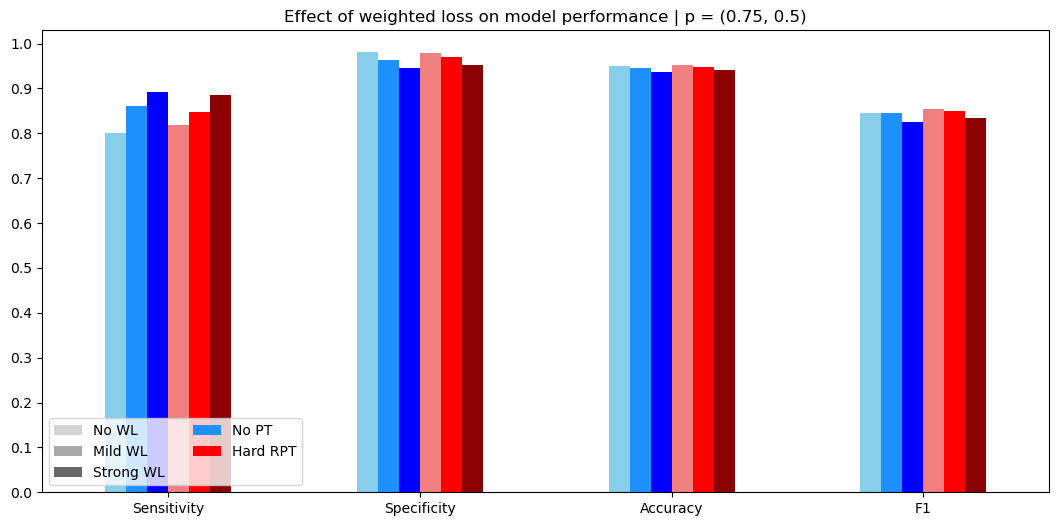

In [19]:
fig, ax = plt.subplots(figsize=(13, 6))

res_df.plot(kind='bar', ax=ax, rot=0, color=colors, legend=False)

no_pt = Rectangle((0,0),1,1,fc="dodgerblue")
rpt = Rectangle((0,0),1,1,fc="red")
no_wl = Rectangle((0,0),1,1,fc="lightgrey")
mild_wl = Rectangle((0,0),1,1,fc="darkgray")
wl = Rectangle((0,0),1,1,fc="dimgrey")

handles = [no_wl, mild_wl, wl, no_pt, rpt]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT']
ax.legend(handles, labels, loc='lower left', fontsize=10, ncols=2)
ax.set_title('Effect of weighted loss on model performance | p = (0.75, 0.5)')
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.show()

In [20]:
ab_stats_list = [r['ab_stats'].set_index('antibiotic') for r in results]
res_df_ab = pd.concat(ab_stats_list, keys=model_names, names=['model']).unstack(level=0)
res_df_ab
reduce_cols = ['num_masked_tot', 'num_masked_S', 'num_masked_R']
df_tmp = res_df_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_tmp.insert(i, col, res_df_ab[col].agg('mean', axis=1))
res_df_ab = df_tmp
S_share = res_df_ab['num_masked_S'] / res_df_ab['num_masked_tot']
R_share = res_df_ab['num_masked_R'] / res_df_ab['num_masked_tot']
res_df_ab[['S_share', 'R_share']] = pd.concat([S_share, R_share], axis=1)
res_df_ab = res_df_ab.sort_values(by='S_share', ascending=False)
res_df_ab

num_masked_tot num_masked_S num_masked_R num_pred_S            \
model                                                     noPT noPT_mild   
antibiotic                                                                 
IPM                 279.0        278.0          1.0        276       276   
MEM                 630.0        627.0          3.0        628       625   
AMK                 302.0        300.0          2.0        302       301   
ETP                 299.0        293.0          6.0        295       294   
TOB                 271.0        255.0         16.0        257       248   
NAL                 337.0        316.0         21.0        321       302   
GEN                 611.0        531.0         80.0        560       537   
CIP                 616.0        517.0         99.0        526       499   
CRO                 553.0        456.0         97.0        454       448   
FEP                 327.0        265.0         62.0        267       253   
LVX                 276.0        204.0         72.0        208       205   
CAZ                 353.0        237.0        116.0        240       228   
AMP                 609.0        332.0        277.0        376       362   
MFX                   5.0          2.0          3.0          1         1   
CTX                  98.0         11.0         87.0         10        10   

                                                           num_pred_R  ...  \
model      noPT_strong hardRPT hardRPT_mild hardRPT_strong       noPT  ...   
antibiotic                                                             ...   
IPM                275     276          275            275          3  ...   
MEM                625     627          626            624          2  ...   
AMK                299     302          301            298          0  ...   
ETP                292     295          293            286          4  ...   
TOB                239     253          243            239         14  ...   
NAL                288     322          312            292         16  ...   
GEN                509     554          532            525         51  ...   
CIP                482     530          522            492         90  ...   
CRO                437     454          453            446         99  ...   
FEP                250     271          258            243         60  ...   
LVX                199     209          206            201         68  ...   
CAZ                221     240          223            218        113  ...   
AMP                346     359          370            358        233  ...   
MFX                  1       1            1              0          4  ...   
CTX                 10      10           10             11         88  ...   

              precision                       F1                        \
model      hardRPT_mild hardRPT_strong      noPT noPT_mild noPT_strong   
antibiotic                                                               
IPM            0.250000       0.250000  0.500000  0.500000    0.400000   
MEM            0.500000       0.500000  0.800000  0.750000    0.750000   
AMK            0.000000       0.000000       NaN       NaN         NaN   
ETP            0.666667       0.384615  0.800000  0.727273    0.615385   
TOB            0.464286       0.468750  0.666667  0.666667    0.625000   
NAL            0.720000       0.466667  0.756757  0.714286    0.600000   
GEN            0.708861       0.662791  0.656489  0.688312    0.637363   
CIP            0.882979       0.733871  0.857143  0.851852    0.815451   
CRO            0.890000       0.859813  0.877551  0.891089    0.882629   
FEP            0.782609       0.690476  0.819672  0.808824    0.805755   
LVX            0.928571       0.920000  0.914286  0.909091    0.912752   
CAZ            0.846154       0.844444  0.882096  0.879668    0.895161   
AMP            0.895397       0.864542  0.819608  0.832061    0.829630   
MFX            0.750000       0.600000  0.857143  0.8

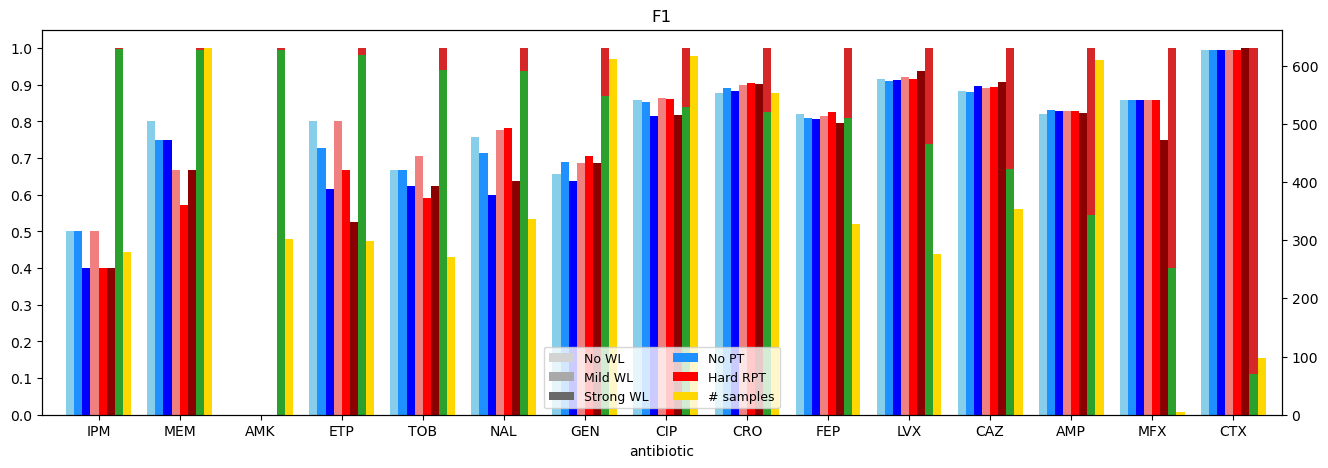

In [21]:
fig, ax = plt.subplots(figsize=(16, 5))

ax2 = ax.twinx()
metric = 'F1'
bar_width = 0.1
for i, model in enumerate(model_names):
    res_df_ab[metric][model].plot(kind='bar', ax=ax, color=colors[i], position=-i+4, width=bar_width, label=model, legend=False, rot=0)

res_df_ab[['S_share', 'R_share']].plot(kind='bar', ax=ax, position=-2, stacked=True, width=bar_width, color=['tab:green', 'tab:red'], rot=0, legend=False)
res_df_ab['num_masked_tot'].plot(kind='bar', ax=ax2, color='gold', label='Total masked', position=-3, width=bar_width, legend=False, rot=0)
ax.set_xlim(-0.7, len(res_df_ab.index)-0.4)
ax.set_title(metric)
ax.set_yticks(np.arange(0, 1.1, 0.1))

n_samples = Rectangle((0,0),1,1,fc="gold")

handles = [no_wl, mild_wl, wl, no_pt, rpt, n_samples]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT', '# samples']
# ax.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)
ax2.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)

plt.show()

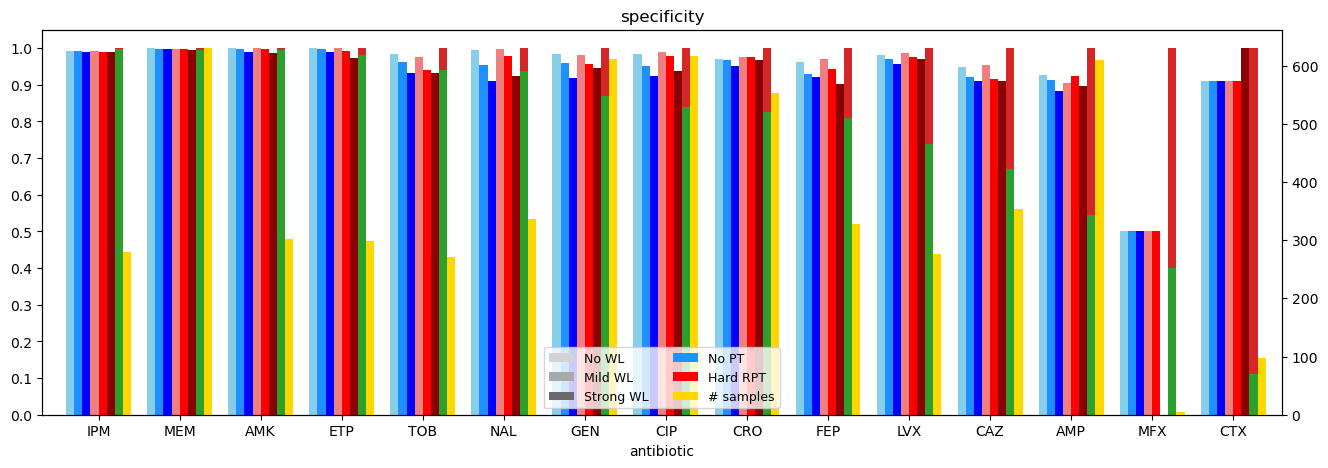

In [22]:
fig, ax = plt.subplots(figsize=(16, 5))

ax2 = ax.twinx()
metric = 'specificity'
bar_width = 0.1
for i, model in enumerate(model_names):
    res_df_ab[metric][model].plot(kind='bar', ax=ax, color=colors[i], position=-i+4, width=bar_width, label=model, legend=False, rot=0)

res_df_ab[['S_share', 'R_share']].plot(kind='bar', ax=ax, position=-2, stacked=True, width=bar_width, color=['tab:green', 'tab:red'], rot=0, legend=False)
res_df_ab['num_masked_tot'].plot(kind='bar', ax=ax2, color='gold', label='Total masked', position=-3, width=bar_width, legend=False, rot=0)
ax.set_xlim(-0.7, len(res_df_ab.index)-0.4)
ax.set_title(metric)
ax.set_yticks(np.arange(0, 1.1, 0.1))

n_samples = Rectangle((0,0),1,1,fc="gold")

handles = [no_wl, mild_wl, wl, no_pt, rpt, n_samples]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT', '# samples']
# ax.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)
ax2.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)

plt.show()

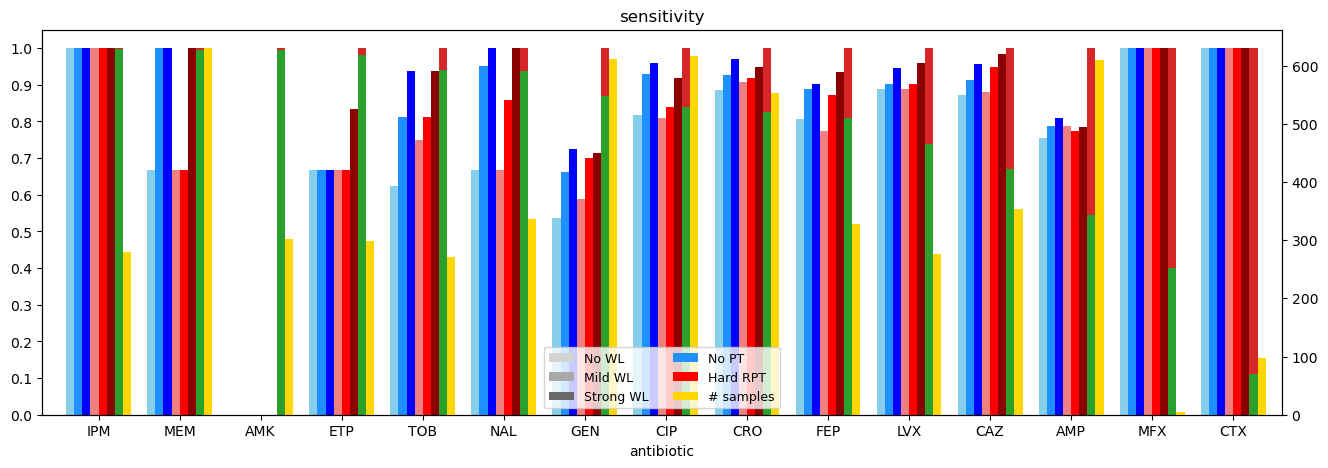

In [23]:
fig, ax = plt.subplots(figsize=(16, 5))

ax2 = ax.twinx()
metric = 'sensitivity'
bar_width = 0.1
for i, model in enumerate(model_names):
    res_df_ab[metric][model].plot(kind='bar', ax=ax, color=colors[i], position=-i+4, width=bar_width, label=model, legend=False, rot=0)

res_df_ab[['S_share', 'R_share']].plot(kind='bar', ax=ax, position=-2, stacked=True, width=bar_width, color=['tab:green', 'tab:red'], rot=0, legend=False)
res_df_ab['num_masked_tot'].plot(kind='bar', ax=ax2, color='gold', label='Total masked', position=-3, width=bar_width, legend=False, rot=0)
ax.set_xlim(-0.7, len(res_df_ab.index)-0.4)
ax.set_title(metric)
ax.set_yticks(np.arange(0, 1.1, 0.1))

n_samples = Rectangle((0,0),1,1,fc="gold")

handles = [no_wl, mild_wl, wl, no_pt, rpt, n_samples]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT', '# samples']
# ax.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)
ax2.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)

plt.show()

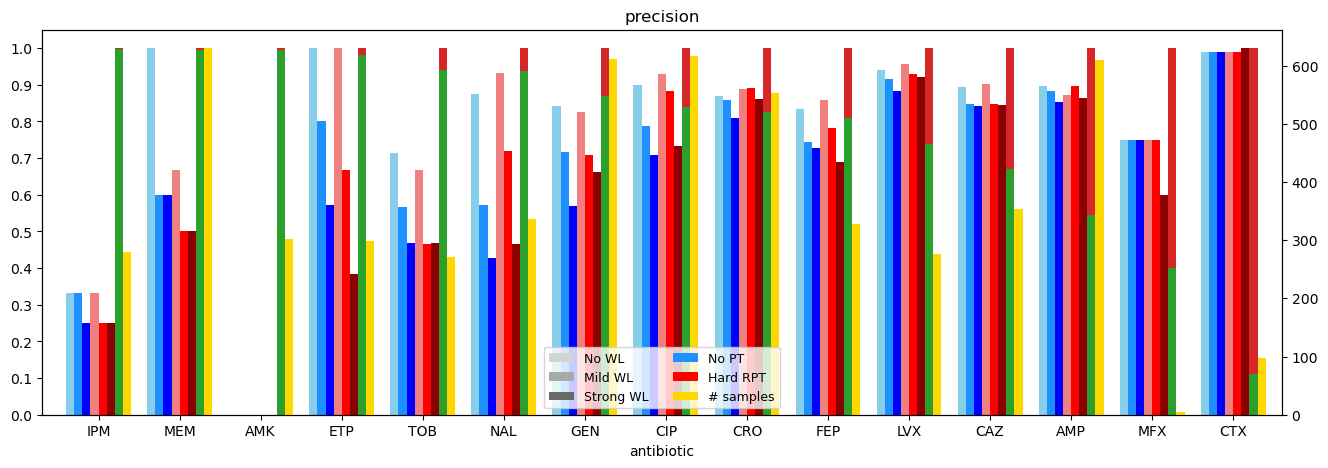

In [24]:
fig, ax = plt.subplots(figsize=(16, 5))

ax2 = ax.twinx()
metric = 'precision'
bar_width = 0.1
for i, model in enumerate(model_names):
    res_df_ab[metric][model].plot(kind='bar', ax=ax, color=colors[i], position=-i+4, width=bar_width, label=model, legend=False, rot=0)

res_df_ab[['S_share', 'R_share']].plot(kind='bar', ax=ax, position=-2, stacked=True, width=bar_width, color=['tab:green', 'tab:red'], rot=0, legend=False)
res_df_ab['num_masked_tot'].plot(kind='bar', ax=ax2, color='gold', label='Total masked', position=-3, width=bar_width, legend=False, rot=0)
ax.set_xlim(-0.7, len(res_df_ab.index)-0.4)
ax.set_title(metric)
ax.set_yticks(np.arange(0, 1.1, 0.1))

n_samples = Rectangle((0,0),1,1,fc="gold")

handles = [no_wl, mild_wl, wl, no_pt, rpt, n_samples]
labels = ['No WL', 'Mild WL', 'Strong WL', 'No PT', 'Hard RPT', '# samples']
# ax.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)
ax2.legend(handles, labels, loc='lower center', fontsize=9, ncols=2)

plt.show()

# Experiment with systematic removal of genes

## Genes in the multimodal dataset

In [3]:
ds_MM = ds_NCBI[ds_NCBI['num_ab'] > 0].copy()
df_genes = ds_MM[['genotypes', 'num_genotypes']]
df_genes['num_genotypes'].describe()

count    6468.000000
mean        6.296691
std         5.065668
min         1.000000
25%         2.000000
50%         4.000000
75%         9.000000
max        40.000000
Name: num_genotypes, dtype: float64

In [4]:
genotypes = ds_MM['genotypes']
genotypes_exploded = genotypes.explode()
gene_counts = genotypes_exploded.value_counts()
gene_counts.describe()

count     336.000000
mean      121.211310
std       444.617562
min         1.000000
25%         1.750000
50%         4.500000
75%        21.000000
max      5890.000000
Name: count, dtype: float64

In [5]:
pd.set_option('display.max_rows', None)
# gene_counts.to_csv('gene_counts.csv')
gene_counts

genotypes
glpT_E448K=POINT                       5890
pmrB_E123D=POINT                       2212
pmrB_Y358N=POINT                       1943
blaTEM-1                               1672
tet(A)                                 1646
sul2                                   1555
aph(3'')-Ib                            1487
uhpT_E350Q=POINT                       1480
aph(6)-Id                              1457
gyrA_S83L=POINT                        1386
sul1                                   1167
tet(B)                                 1155
parC_S80I=POINT                        1034
cyaA_S352T=POINT                       1014
gyrA_D87N=POINT                         998
marR_S3N=POINT                          791
aadA1                                   776
mph(A)                                  773
dfrA17                                  722
ptsI_V25I=POINT                         713
aadA5                                   652
parE_I529L=POINT                        634
blaCTX-M-15           

In [6]:
filter_by = ['bla']
ds_MM['genotypes_filtered'] = ds_MM['genotypes'].apply(lambda x: [g for g in x if not any(f in g for f in filter_by)])
ds_MM['num_genotypes_filtered'] = ds_MM['genotypes_filtered'].apply(len)
ds_MM['num_genotypes_filtered'].describe()

count    6468.000000
mean        5.662956
std         4.495780
min         0.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        33.000000
Name: num_genotypes_filtered, dtype: float64

In [7]:
filtered_out = ds_MM['genotypes'].apply(lambda x: [g for g in x if any([f in g for f in filter_by])])
filtered_out.explode().value_counts()

genotypes
blaTEM-1                          1672
blaCTX-M-15                        536
blaCMY-2                           289
blaOXA-1                           278
blaHER-3                           181
blaCTX-M-27                        178
blaCTX-M-1                         169
blaCTX-M-55                        111
blaTEM=PARTIAL_END_OF_CONTIG       104
blaCTX-M-14                         89
blaSHV-12                           51
blaTEM                              32
blaSHV-1                            26
blaNDM-1                            23
blaHER                              21
blaDHA-1                            20
blaCTX-M                            15
blaTEM-52                           15
blaCMY-42                           15
blaCARB-2                           15
blaCMY=PARTIAL_END_OF_CONTIG        14
blaNDM-5                            14
blaKPC-3                            13
blaCMY-6                            12
blaCTX-M-32                         12
blaCMY         

## Results

### Removing all *bla* genes

#### Antibiotic-level

In [74]:
model_names = ['No PT', 'Easy RPT', 'Medium RPT', 'Hard RPT']
exp_folder = '2024_03_15'
save_results = False
df_CV_ab = load_and_create_ab_df('0_0.75', model_names=model_names, exp_folder=exp_folder)
df_CV_ab_no_bla = load_and_create_ab_df('no_bla_0_0.75', model_names=model_names, exp_folder=exp_folder)
beta_lactams = ['Penicillins', 'Cephalosporins', 'Carbapenems', 'Monobactams']

#### Compare model-wise differences to measure resilience to loss of *bla* genes in training data

In [75]:
def calculate_ab_level_differences(
    df_ab_0, 
    df_ab_1, 
    metrics=['sensitivity', 'specificity', 'precision', 'F1'], 
    num_folds = 5,
):
    df_diff = df_ab_1.copy()
    for metric in metrics:
        avg = metric+'_avg'
        std = metric+'_std'
        df_diff[avg] = df_ab_1[avg] - df_ab_0[avg]
        df_diff[std] = np.sqrt((df_ab_0[std]**2 + df_ab_1[std]**2)/num_folds)
    return df_diff  

def plot_ab_level_differences(
    df_diff_ab,
    plot_metric,
    figsize=(13, 6),
    plot_title=None,
    colors=['slategray', 'forestgreen', 'gold', 'red'],
    ab_classes=None,
    savepath=None
):
    if ab_classes:
        df_diff_plot = df_diff_ab[df_diff_ab['ab_class'].isin(ab_classes)]
    else:
        df_diff_plot = df_diff_ab
    _, ax = plt.subplots(figsize=figsize)
    df_diff_plot.plot(kind='bar', y=plot_metric+'_avg', yerr=plot_metric+'_std', ax=ax, rot=0, capsize=2, color=colors)
    if ab_classes:
        ax.set_xlabel('Antibiotics in classes: ' + ', '.join(ab_classes))
    else:
        ax.set_xlabel('Antibiotic')
    if plot_title:
        ax.set_title(plot_title)
    else:
        ax.set_title(f'Model-wise differences in {plot_metric}')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=300)
    plt.show()          

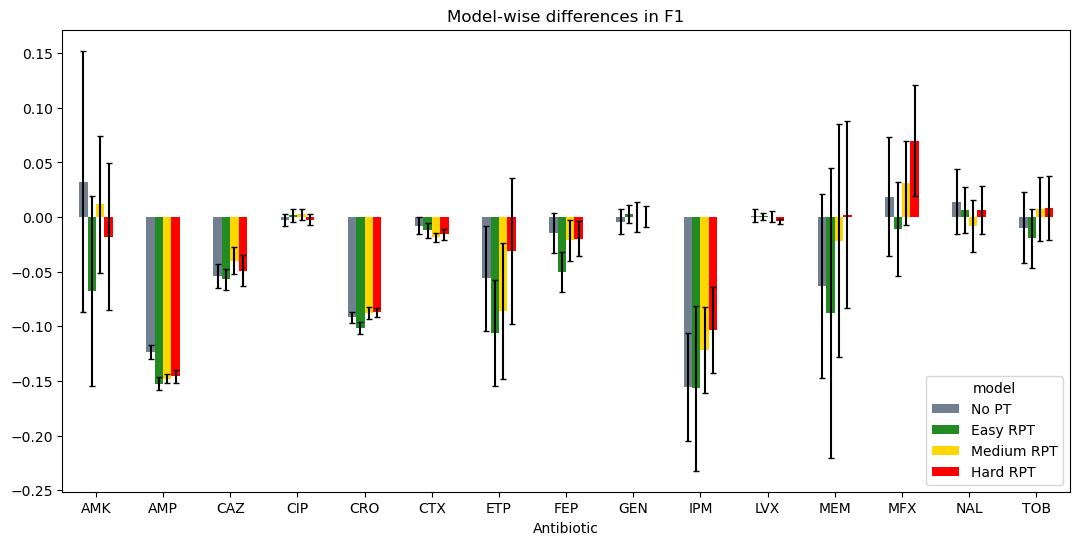

In [76]:
df_diff_ab = calculate_ab_level_differences(df_CV_ab, df_CV_ab_no_bla)
plot_ab_level_differences(df_diff_ab, 'F1')

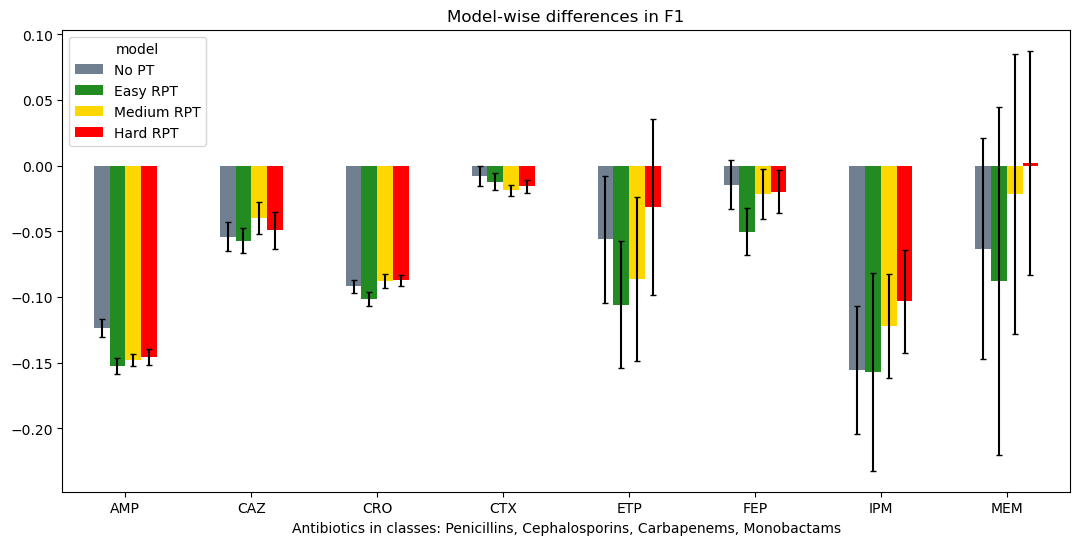

In [77]:
plot_ab_level_differences(df_diff_ab, 'F1', ab_classes=beta_lactams)

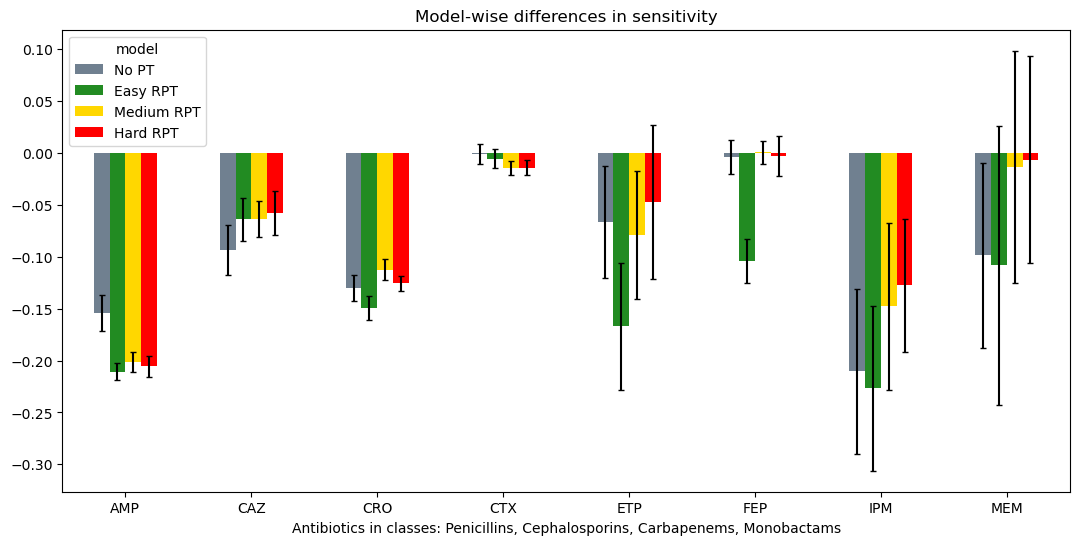

In [78]:
plot_ab_level_differences(df_diff_ab, 'sensitivity', ab_classes=beta_lactams)

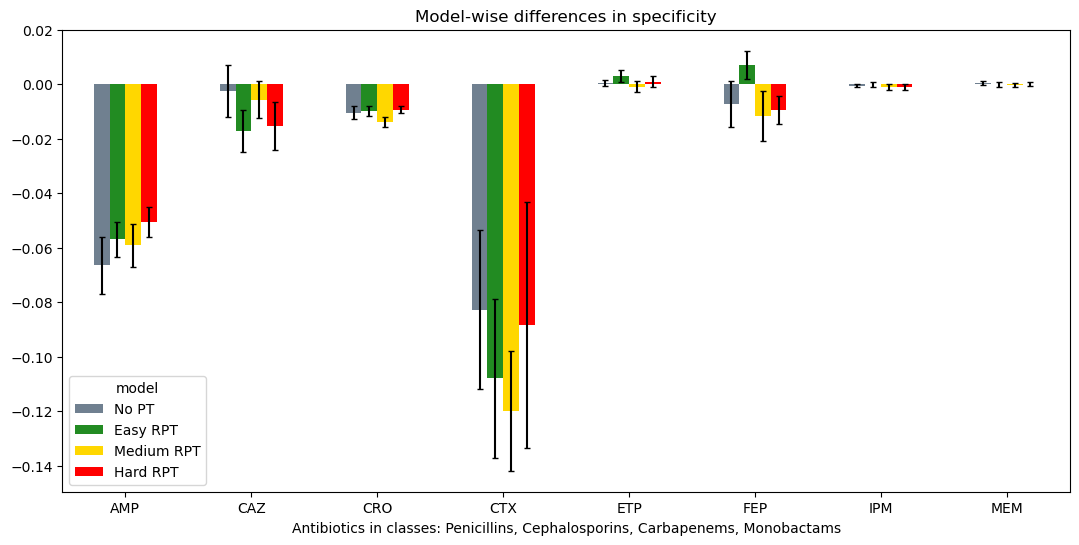

In [79]:
plot_ab_level_differences(df_diff_ab, 'specificity', ab_classes=beta_lactams)

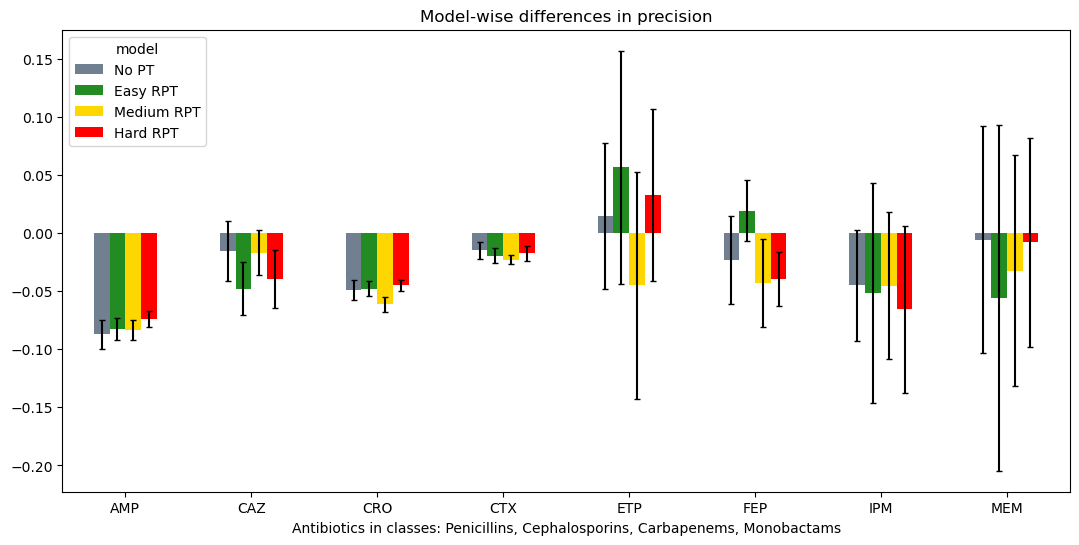

In [80]:
plot_ab_level_differences(df_diff_ab, 'precision', ab_classes=beta_lactams)

#### Relative differences to model without PT for both presence and abscence of *bla* genes

In [119]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs('0_0.75', model_names=model_names, exp_folder=exp_folder)
df_CV_no_bla, df_diff_no_bla = load_and_create_abs_and_rel_diff_dfs('no_bla_0_0.75', model_names=model_names, exp_folder=exp_folder)
drop_metrics = ['Loss', 'Accuracy']

In [ ]:
df

In [120]:
df_CV.drop(columns=drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(13, 6), capsize=2, color=colors)

KeyError: 'Loss'

### Isolate-level

In [81]:
results_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', exp_folder, 'FT_noPT_0_0.75', 'CV_results.pkl'))
results_noPT_no_bla = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', exp_folder, 'FT_noPT_no_bla_0_0.75', 'CV_results.pkl'))

In [88]:
iso_stats = results_noPT['iso_stats'][0]
iso_stats_no_bla = results_noPT_no_bla['iso_stats'][0]

In [101]:
iso_stats['genotypes']

0                    [glpT_E448K=POINT, pmrB_Y358N=POINT]
1       [ptsI_V25I=POINT, blaCTX-M-15, tet(A), parC_E8...
2       [tet(B), blaTEM-1, glpT_E448K=POINT, cyaA_S352...
3                    [glpT_E448K=POINT, pmrB_Y358N=POINT]
4                    [glpT_E448K=POINT, uhpT_E350Q=POINT]
5       [dfrA1, tet(A), aph(3'')-Ib, cyaA_S352T=POINT,...
6       [tet(B), glpT_E448K=POINT, aph(6)-Id, mph(A), ...
7         [tet(B), glpT_E448K=POINT, sat2, lnu(F), aadA1]
8       [qnrB4, tet(A), mph(A), glpT_E448K=POINT, blaD...
9            [glpT_E448K=POINT, pmrB_Y358N=POINT, tet(C)]
10      [ptsI_V25I=POINT, tet(A), mph(A), pmrB_E123D=P...
11                   [glpT_E448K=POINT, pmrB_Y358N=POINT]
12      [tet(A), aadA25, blaCTX-M-14, tet(M), floR, me...
13      [tet(B), glpT_E448K=POINT, pmrB_Y358N=POINT, s...
14                   [glpT_E448K=POINT, pmrB_E123D=POINT]
15                   [glpT_E448K=POINT, pmrB_E123D=POINT]
16                             [tet(B), glpT_E448K=POINT]
17            

In [107]:
iso_stats_containing_bla = iso_stats[iso_stats['genotypes'].apply(lambda x: any([f in g for f in filter_by for g in x]))]
iso_stats_no_bla_containing_bla = iso_stats_no_bla[iso_stats_no_bla['genotypes'].apply(lambda x: any([f in g for f in filter_by for g in x]))]

In [112]:
iso_acc = iso_stats_containing_bla['all_correct'].mean()
iso_acc_no_bla = iso_stats_no_bla_containing_bla['all_correct'].mean()
iso_acc, iso_acc_no_bla

(0.8314785373608903, 0.6693163751987281)